# This notebook goes with Lesson 10, Section 7 of the Tensorflow 2.0 course on Udacity. It uses Bidirectional LSTM layers for sentiment analysis. 

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features['label'].num_classes)
print(info.features['label'].names)

Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteYVKON2/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteYVKON2/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteYVKON2/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [5]:
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [6]:
for example in dataset_train.take(2):
    review, label = example['sentence'], example['label']
    print("Review: ", review)
    print("Label: %d \n" % label.numpy())

Review:  tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review:  tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [10]:
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

for item in dataset_train.take(10000):
    review, label = item['sentence'], item['label']
    training_reviews.append(str(review.numpy()))
    training_labels.append(label.numpy())
    
print('\nNumber of training reviews is: ', len(training_reviews))

for i in range(0, 2):
    print(training_reviews[i]),
    print(training_labels[i])

for item in dataset_validation.take(-1):
    review, label = item['sentence'], item['label']
    validation_reviews.append(str(review.numpy()))
    validation_labels.append(label.numpy())
    
for i in range(0, 2):
    print(validation_reviews[i])
    print(validation_labels[i])
        


Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


## Tokenize and Sequence

In [11]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

In [12]:
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,
                               maxlen = max_length,
                               padding=padding_type,
                               truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,
                                 maxlen = max_length,
                                 padding=padding_type,
                                 truncating=trunc_type)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

## Create model using Embedding

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                             embedding_dim,
                             input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='relu')
])
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                   validation_data = (validation_padded, validation_labels_final))

Epoch 1/20
313/313 [==============================] - 1s 3ms/step - loss: 0.8132 - accuracy: 0.4955 - val_loss: 0.6828 - val_accuracy: 0.5562
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6584 - accuracy: 0.6155 - val_loss: 0.6591 - val_accuracy: 0.6181
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6342 - accuracy: 0.6548 - val_loss: 0.6297 - val_accuracy: 0.6628
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6029 - accuracy: 0.6890 - val_loss: 0.5932 - val_accuracy: 0.6972
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.7289 - val_loss: 0.5659 - val_accuracy: 0.7225
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5163 - accuracy: 0.7611 - val_loss: 0.5453 - val_accuracy: 0.7362
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4701 - accuracy: 0.7890 - val_loss: 0.5375 - val_accuracy: 0.7615
Epoch 

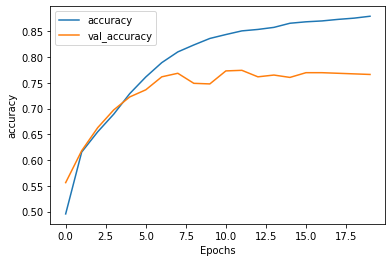

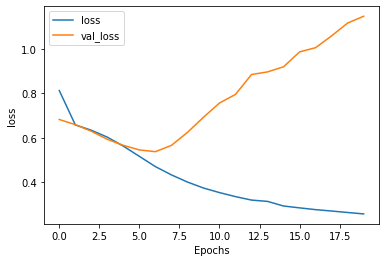

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [18]:
def predict_review(model, reviews):
    padding_type = 'post'
    trunc_type = 'post'
    sample_sequences = tokenizer.texts_to_sequences(reviews)
    reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                  maxlen=max_length)
    classes = model.predict(reviews_padded)
    for x in range(len(reviews_padded)):
        print(reviews[x])
        print(classes[x])
        print('\n')
    

In [19]:
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

predict_review(model, new_reviews)

I loved this movie
[0.49704635]


that was the worst movie I've ever seen
[0.02082119]


too much violence even for a Bond film
[0.]


a captivating recounting of a cherished myth
[0.6585384]




## Streamlining Function

In [20]:
def fit_model_and_show_results(model, reviews):
    model.summary()
    history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                       validation_data = (validation_padded, validation_labels_final))
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    predict_review(model, reviews)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.5949 - val_loss: 0.6095 - val_accuracy: 0.7259
Epoch 2/30
313/313 [==============================] - 1s 3ms/step - loss: 0.4665 - accuracy: 0.7838 - val_

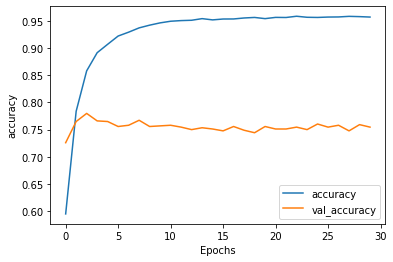

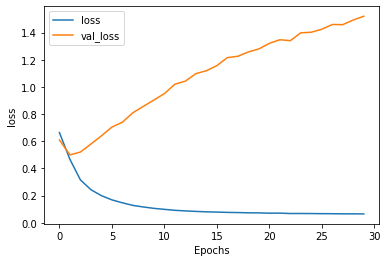

I loved this movie
[0.9999989]


that was the worst movie I've ever seen
[3.232885e-06]


too much violence even for a Bond film
[1.0325915e-12]


a captivating recounting of a cherished myth
[0.9995721]




In [24]:
# CNN
num_epochs = 30
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                             embedding_dim,
                             input_length = max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0001
model_cnn.compile(optimizer = 'adam',
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 10s 33ms/step - loss: 0.6012 - accuracy: 0.6533 - val_loss: 0.5517 - val_accuracy: 0.7213
Epoch 2/30
313/313 [==============================] - 10s 31ms/step - loss: 0.3834 - accuracy: 0.8194 - val_loss: 0.5331 - val_accuracy: 0.7443
Epoch 3/30
313/313 [==============================] - 9s 30ms/step - loss: 0.3022 - accuracy

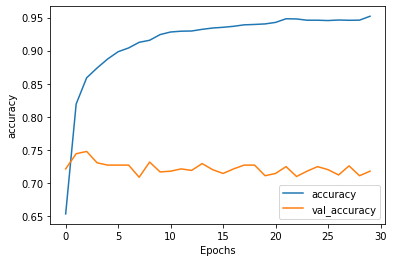

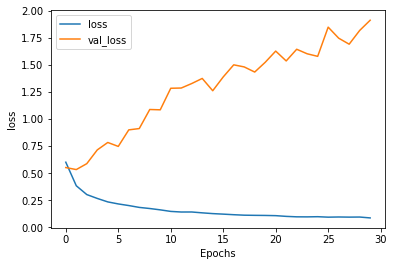

I loved this movie
[0.99881786]


that was the worst movie I've ever seen
[0.00524023]


too much violence even for a Bond film
[2.3949786e-05]


a captivating recounting of a cherished myth
[0.99993885]




In [25]:
# GRU
num_epochs = 30

model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                             embedding_dim,
                             input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_GRU.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics=['accuracy'])

fit_model_and_show_results(model_GRU, new_reviews)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 8s 27ms/step - loss: 0.6238 - accuracy: 0.6352 - val_loss: 0.5514 - val_accuracy: 0.7259
Epoch 2/30
313/313 [==============================] - 7s 23ms/step - loss: 0.4156 - accuracy: 0.8065 - val_loss: 0.5216 - val_accuracy: 0.7695
Epoch 3/30
313/313 [==============================] - 7s 23ms/step - loss: 0.3193 - accuracy: 

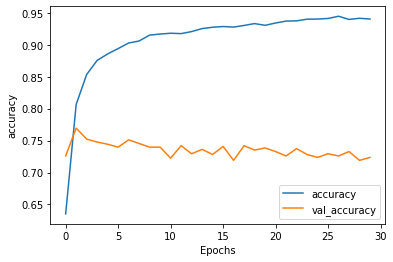

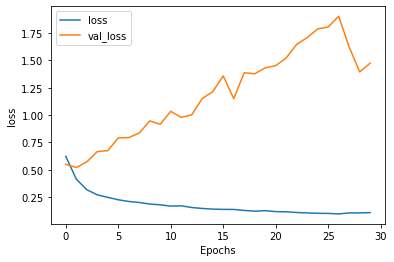

I loved this movie
[0.84484446]


that was the worst movie I've ever seen
[0.08334109]


too much violence even for a Bond film
[0.00075114]


a captivating recounting of a cherished myth
[0.9972917]




In [26]:
# Single Bidirectional LSTM
num_epochs = 30

model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                             embedding_dim,
                             input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
learning_rate = 0.0003
model_LSTM.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

fit_model_and_show_results(model_LSTM, new_reviews)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 17s 54ms/step - loss: 0.5977 - accuracy: 0.6605 - val_loss: 0.5313 - val_accuracy: 0.7362
Epoch 2/30
313/313 [==============================] - 15s 49ms/step - loss: 0.3744 - accuracy: 0.8239 - 

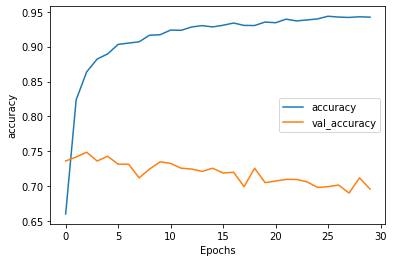

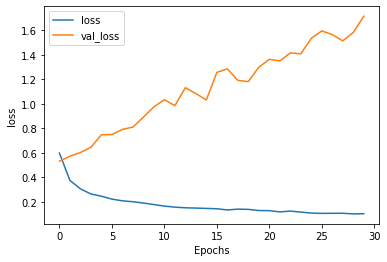

I loved this movie
[0.9949963]


that was the worst movie I've ever seen
[0.48979294]


too much violence even for a Bond film
[0.01290712]


a captivating recounting of a cherished myth
[0.99711454]




In [28]:
# Multiple Bidirectional LSTM
num_epochs = 30

model_double_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                             embedding_dim,
                             input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                      return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
learning_rate = 0.0003
model_double_LSTM.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

fit_model_and_show_results(model_double_LSTM, new_reviews)